In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics  import classification_report

Plot the accuracy vs the number of observations for our RNN.

In [2]:
survey = 'Gaia'
# survey='PanStarrs'
# survey = 'ZTF'

In [3]:
# Load the metadata, to get the length.
if survey=='Gaia':
    path_metadata = './../../../../../Prepare_dataset/Gaia/V5/Dataset_Gaia_Phys_V5.dat'
    cols = ['ID','N', 'N_b', 'N_r']
    # path_rf = '../../../../../RandomForestBaseline/Compute_TurboFATS_v2/Gaia/Results/Pred_RBF_Gaia_Fold_1.dat'
elif survey=='PanStarrs':
    path_metadata = '../../../../../Prepare_dataset/PanStarrs/Dataset_PanStarrs_V2_ParamPhys.dat'
    cols =['ID','N','N_g', 'N_r', 'N_i', 'N_z', 'N_y']
    # path_rf = '../../../../../RandomForestBaseline/Compute_TurboFATS_v2/PanStarrs/Results/Pred_RBF_PanStarrs_Fold_1.dat'
elif survey=='ZTF':
    path_metadata = '../../../../../../Databases/ALeRCE/Sánchez-Sáez et al.2021/metadata.csv'
    cols =['ID', 'N','N_1', 'N_2']

In [4]:
# Load the metadata
metadata = pd.read_csv(path_metadata, usecols=cols)

Load RNN results

In [5]:
path = '../04_Compute_Metrics/'+survey+'/Results/*.dat'
folds_rnn = glob(path)
folds_rnn.sort()

Load RF results

In [6]:
path_rf = '../../../../../RandomForestBaseline/Compute_TurboFATS_v2/'+survey+'/Results/*.dat'
folds_rf = glob(path_rf)
folds_rf.sort()

In [7]:
dfs_rnn = []
for fold in folds_rnn:

    # Load RNN results
    pred_rnn = pd.read_csv(fold)
    pred_rnn.index.name = 'ID'

    df_rnn = pd.merge(pred_rnn[['Class', 'Pred']], metadata[cols], on='ID', how='inner')    
    dfs_rnn.append(df_rnn)
dfs_rf = []
for fold in folds_rf:
   # Load RF results
    pred_rf = pd.read_csv(fold)
    pred_rf.rename({'oid':'ID'}, axis=1, inplace=True)
    pred_rf.set_index('ID', inplace=True)
    df_rf = pd.merge(pred_rf[['Class', 'Pred']], metadata[cols], on='ID', how='inner')        
    dfs_rf.append(df_rf)

In [8]:
# Set the default interval each 10 observations, using the first fold
df_rnn = dfs_rnn[0]
df_rf = dfs_rf[0]

if survey=='Gaia':
    interval = 10
    delta = interval/2
    N_max = np.ceil(df_rnn.N.max()/interval)
    XX = np.arange(25, N_max*interval, interval)
if survey=='PanStarrs':
    interval = 10
    delta = interval/2
    N_max = np.ceil(df_rnn.N.max()/interval)
    XX = np.arange(10, N_max*interval, interval)
if survey=='ZTF':
    interval = 50
    delta = interval/2
    N_max = np.ceil(df_rnn.N.max()/interval)
    XX = np.arange(10, N_max*interval, interval)    

For each proposed bin, count the number of elements in the bin. If smaller than 10, they will be merged.

In [9]:
# Compute the number of elements per bin using default values
N = []
deltas = []
for i in range(len(XX)):
    x = XX[i]
    deltas.append(delta)
    # Define the intervals
    below = x-delta
    above = x+delta
    # Create the bined dataframe for each model type
    b1 = df_rnn.N>=below
    b2 = df_rnn.N<above
    b = np.logical_and(b1, b2)
    sel_rnn = df_rnn[['Class', 'Pred', 'N']][b]
    
    N.append(sel_rnn.shape[0])

# Some bins have a vero low count. Merge bins of the boundaries.
new_XX = list(XX).copy()
new_N = N.copy()
new_deltas = deltas.copy()

N_min = 10
condition_while=True
new_start = 0

while_exit=0
while condition_while:
    cond_for = False

    for i in range(new_start, len(new_N)):
        N_temp = new_N[i]
        X_temp = new_XX[i]
        d_temp = new_deltas[i]
        if N_temp<N_min and i<len(new_N)-1:
            # Create the new bin
            X_temp = (new_XX[i]+new_XX[i+1])/2
            d_temp = new_deltas[i]+deltas[i+1]
            N_temp = new_N[i]+new_N[i+1]

            # Remove the last one
            new_XX.pop(i+1)
            new_deltas.pop(i+1)
            new_N.pop(i+1)

            # Replace the new values
            new_XX[i] = X_temp
            new_deltas[i] = d_temp
            new_N[i] = N_temp

            # Break the for loop and start again
            cond_for = True
            
        elif N_temp<N_min and i==len(new_N)-1:
            # Create the new bin
            X_temp = (new_XX[i-1]+new_XX[i])/2
            d_temp = new_deltas[i-1]+deltas[i]
            N_temp = new_N[i-1]+new_N[i]            

            # Remove the last one
            new_XX.pop(i)
            new_deltas.pop(i)
            new_N.pop(i)
          
            # Replace the new values
            new_XX[i-1] = X_temp
            new_deltas[i-1] = d_temp
            new_N[i-1] = N_temp
            
            condition_while=False   
                
        # If found a bin, break
        if cond_for:
            break    
    while_exit+=1
    if while_exit>25:
        condition_while=False
new_XX = np.array(new_XX).astype(int)
new_deltas = np.array(new_deltas)    

Once the new bins have been found, compute the metrics.

In [10]:
# Create the containers
# ACC_rnn = []
# ACC_rf = []
# REP_rnn = []
# REP_rf = []
REPORTs = []
ACCs = []

# For each bin
for i in range(len(new_XX)):
    
    REPORT = {'RNN':[], 'RF':[]}
    ACC = {'RNN':[], 'RF':[]}    
    # Define the intervals
    below = new_XX[i]-new_deltas[i]
    above = new_XX[i]+new_deltas[i]    
    # For each fold
    for j in range(len(dfs_rnn)):
        # Get the corresponding results of RNN
        df_rnn = dfs_rnn[j]
        # Create the bined dataframe for each model type
        b1 = df_rnn.N>=below
        b2 = df_rnn.N<above
        b = np.logical_and(b1, b2)
        sel_rnn = df_rnn[['Class', 'Pred', 'N']][b]
        
        # Get the corresponding results of RF
        df_rf = dfs_rf[j]
        # Create the bined dataframe for each model type
        b1 = df_rf.N>=below
        b2 = df_rf.N<above
        b = np.logical_and(b1, b2)
        sel_rf = df_rf[['Class', 'Pred', 'N']][b]

        # # Compute the accuracy
        # acc_rnn = np.sum(sel_rnn['Pred']==sel_rnn['Class'])/sel_rnn.shape[0]
        # acc_rf= np.sum(sel_rf['Pred']==sel_rf['Class'])/sel_rf.shape[0]
        
        # Compute the reports
        rep_RNN = classification_report(sel_rnn['Class'],sel_rnn['Pred'], output_dict=True, zero_division=0)
        rep_RF = classification_report(sel_rf['Class'],sel_rf['Pred'], output_dict=True, zero_division=0)
        
        # Aggregate results
  
        REPORT['RNN'].append(rep_RNN)
        REPORT['RF'].append(rep_RF)
    REPORTs.append(REPORT)


Compute the median and dispersion, per bin

In [11]:
F1 = {'RNN':[], 'RF':[]}

for key in ['RNN', 'RF']:
    for bin_ in range(len(REPORTs)):

        report = REPORTs[bin_][key]
        F1s = [report[i]['macro avg']['f1-score'] for i in range(len(report))]

        mean, std = np.mean(F1s), np.std(F1s)
        F1[key].append([mean, std])
    F1[key] = np.array(F1[key])

Plot the graphs

In [12]:


# Custom ticks 
if survey=='Gaia':
    xticks = [i for i in range(new_XX.shape[0])  if new_XX[i]>125 or i%2==0  ]
    delta = 2
    width_ = interval-6
elif survey=='PanStarrs':
    xticks = [i for i in range(new_XX.shape[0])]
    delta = 2
    width_ = interval-6
elif survey=='ZTF':
    xticks = [i for i in range(new_XX.shape[0])]
    width_ = interval/3
    delta = width_/2

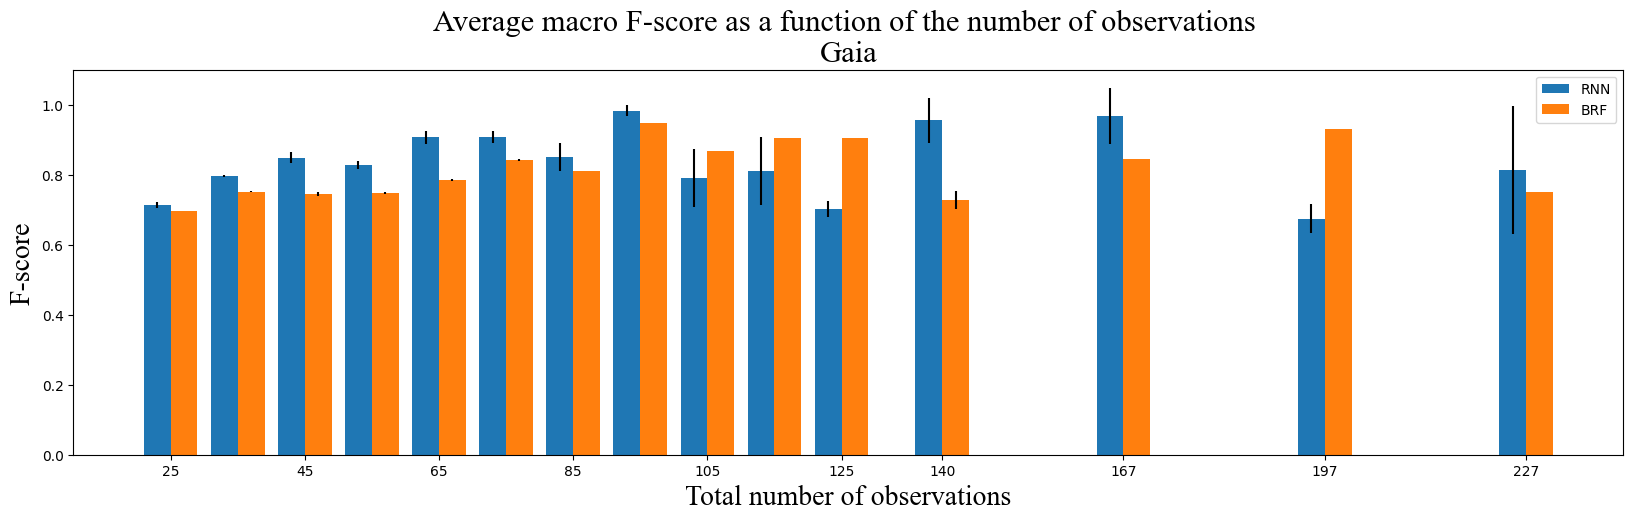

In [13]:
plt.figure(figsize=(20,5))

fmt = {'fontsize':20, 'fontname':'Times New Roman'}
fmt_title = {'fontsize':22, 'fontname':'Times New Roman'}

plt.bar(new_XX-delta, F1['RNN'][:,0], width=width_, label='RNN')
plt.errorbar(new_XX-delta, F1['RNN'][:,0], yerr=F1['RNN'][:,1],fmt='none', color='black')

plt.bar(new_XX+delta, F1['RF'][:,0], width=width_, label='BRF')
plt.errorbar(new_XX+delta, F1['RF'][:,0], yerr=F1['RF'][:,1],fmt='none', color='black')
plt.xlabel('Total number of observations', **fmt)
plt.legend(loc=0)
plt.xticks(new_XX[xticks])
plt.title('Average macro F-score as a function of the number of observations \n'+survey, **fmt_title)
plt.ylabel('F-score', **fmt)
plt.savefig(survey+'.png', dpi=250,format='png' )
plt.show()